In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

In [47]:
class Renormalization:

    def __init__(self, g, num_patches_per_dim, autoplot=True):

        self.g = g
        self.num_patches_per_dim = num_patches_per_dim
        self.num_patches = self.num_patches_per_dim**2
        self.patch_side_length = 1.0 / self.num_patches_per_dim
        self.translations = np.array([self.patch_side_length, self.patch_side_length])

        self.super_V_coords, self.patch_coords, self.V_to_super_V = self.partition_graph()

        if autoplot:
            self.plot_patching(figsize=5)

    def partition_graph(self):
        
        super_V_coords = []
        V_to_super_V = {}
        super_V_to_V = collections.defaultdict(list)
        patch_coords = []

        # Create the patch_coords
        for row in range(self.num_patches_per_dim):
            for col in range(self.num_patches_per_dim):
                center_x = (col + 0.5) * self.patch_side_length
                center_y = (row + 0.5) * self.patch_side_length
                patch_coords.append([center_x, center_y])
        patch_coords = np.array(patch_coords)

        # Assign each vertex to the corresponding patch
        for v_num, (x, y) in enumerate(self.g.V_coords):
            patch_row = np.floor(x / self.patch_side_length).astype(int)
            patch_col = np.floor(y / self.patch_side_length).astype(int)
            patch_index = patch_col * self.num_patches_per_dim + patch_row
            V_to_super_V[v_num] = {"tile_num": patch_index, 
                                   "tile_index": np.array([patch_col, patch_row])}
            super_V_to_V[patch_index].append(v_num)
            
        # Create super_V_coords
        super_V_coords = []
        for patch_index in super_V_to_V:
            super_V_coords.append(np.mean(self.g.V_coords[super_V_to_V[patch_index]], axis=0))
        super_V_coords = np.array(super_V_coords)        

        return super_V_coords, patch_coords, V_to_super_V
    
    def construct_E_data(self):
        """Needs to take in super_V_coords, and construct new connectivity between them
        based on connectivity of old graph. Then run through every edge in old graph
        and construct data (r_ij, l_vw). 
        """
        E_data = {}

        for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
            E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

            if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                i_index, j_index = self.V_to_super_V[v]["tile_index"].copy(), self.V_to_super_V[w]["tile_index"].copy()
                r_ij = j_index - i_index
                r_ij[r_ij == self.kwargs["tiles_per_dim"] - 1] = -1
                r_ij[r_ij == -(self.kwargs["tiles_per_dim"] - 1)] = 1
                r_ij = r_ij * self.translations
            else:
                i_num, j_num = self.V_to_super_V[v]["tile_num"], self.V_to_super_V[w]["tile_num"]
                r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

            E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def plot_patching(self, figsize=10, return_figax=False, linewidth=2):

        fig, ax = self.g.plot_graph(return_figax=True, figsize=figsize, linewidth=linewidth)
        for center in self.super_V_coords:
            bottom_corner = (center[0] - self.patch_side_length / 2, center[1] - self.patch_side_length / 2)
            square = matplotlib.patches.Rectangle(bottom_corner, self.patch_side_length, self.patch_side_length,
                                                  linewidth=2 * linewidth, 
                                                  edgecolor='r', facecolor=(0.8, 0.8, 0.8, 0.1), alpha=1)
            ax.add_patch(square)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        if return_figax:
            return fig, ax
        plt.show()

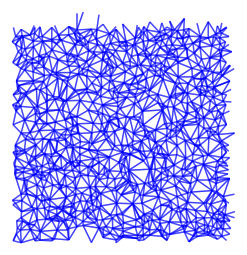

In [48]:
N = 1
np.random.seed(0)
num_Vs_for_tile = 1000
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile, 
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
g.plot_graph(figsize=3, linewidth=1, capstyle=False)

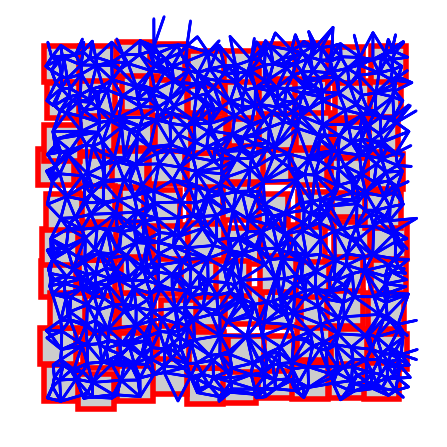

In [49]:
num_patches_per_dim = 10
R = Renormalization(g, num_patches_per_dim=num_patches_per_dim)

In [ ]:
class Laplace_Operator_Graph_Renormalization:
    """Take in g and partition type
    """
    def __init__(self, g, partition_type="tile", **kwargs):

        self.g = g
        self.partition_type = partition_type
        self.kwargs = kwargs
        self.super_V_coords, self.V_to_super_V, self.translations = self.partition_graph()
        self.E_data = self.construct_E_data()

    def partition_graph(self):
        """Partition graph based into subgraphs and return graph "super" graph consisting
        of vertices corresponding to subgraphs, connected if any of the corresponding 
        sub-vertices are. Partitions by type:
        :
            - "by_tile": uses tiling construction from Tiling class. Partitions
                        vertex set just by vertex indices

            - "by_geometric_patch": subdivides square into smaller square patches
                                    and partitions vertex set into those falling
                                    in each patch

        Returns super_V_coords: coords of vertex clumps, 
                V_to_super_V: maps graph V_coords to super graph super_V_coords
        """
        if self.partition_type == "tile":
            super_V_coords = []
            V_to_super_V = {}
            tile_index_to_tile_num = {}

            tile_num = -1 
            for j in range(self.g.num_vertical_displacements):
                for i in range(self.g.num_horizontal_displacements):
                    tile_num += 1
                    v_indices = np.arange(tile_num * self.g.num_Vs_for_tile, (tile_num + 1) * self.g.num_Vs_for_tile)
                    tile = self.g.V_coords[v_indices]
                    super_V_coords.append(np.mean(tile, axis=0))
                    for v_index in v_indices:
                        V_to_super_V[v_index] = {"tile_num": tile_num, "tile_index": np.array([i, j])}

                    tile_index_to_tile_num[i, j] = tile_num

            # Calculate x, y translations by looking at displacements between tiles
            if self.g.num_horizontal_displacements < 2: 
                if self.g.horizontal_displacement < self.g.vertical_displacement:
                    x_translation = self.g.horizontal_displacement / self.g.vertical_displacement
                else:
                    x_translation = 1
            else: 
                x_translation = (super_V_coords[tile_index_to_tile_num[1, 0]] - super_V_coords[tile_index_to_tile_num[0, 0]])[0]
            if self.g.num_vertical_displacements < 2: 
                if self.g.vertical_displacement < self.g.horizontal_displacement:
                    y_translation = self.g.vertical_displacement / self.g.horizontal_displacement
                else:
                    y_translation = 1 
            else: 
                y_translation = (super_V_coords[tile_index_to_tile_num[0, 1]] - super_V_coords[tile_index_to_tile_num[0, 0]])[1]

        elif self.partition_type == "geometric_patch":
            super_V_coords = []
            V_to_super_V = {}
            tile_index_to_tile_num = bidict.bidict()

            # Determine the size of each patch
            patch_size = 1.0 / self.kwargs["tiles_per_dim"]

            # Create the super_V_coords and tile_index_to_tile_num
            for j in range(self.kwargs["tiles_per_dim"]):
                for i in range(self.kwargs["tiles_per_dim"]):
                    center_x = (i + 0.5) * patch_size
                    center_y = (j + 0.5) * patch_size
                    patch_index = j * self.kwargs["tiles_per_dim"] + i
                    super_V_coords.append([center_x, center_y])
                    tile_index_to_tile_num[i, j] = patch_index

            # Assign each vertex to the corresponding patch
            for idx, (x, y) in enumerate(self.g.V_coords):
                patch_i = np.floor(x / patch_size).astype(int)
                patch_j = np.floor(y / patch_size).astype(int)
                patch_index = patch_j * self.kwargs["tiles_per_dim"] + patch_i
                V_to_super_V[idx] = {"tile_num": patch_index, "tile_index": np.array(tile_index_to_tile_num.inv[patch_index])}

            x_translation, y_translation = patch_size, patch_size

        super_V_coords = np.array(super_V_coords)

        translations = np.array([x_translation, y_translation])

        return super_V_coords, V_to_super_V, translations

    def construct_E_data(self):
        """Needs to take in super_V_coords, and construct new connectivity between them
        based on connectivity of old graph. Then run through every edge in old graph
        and construct data (r_ij, l_vw). 
        """
        E_data = {}

        if self.partition_type == "tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}
                
                i, j = self.V_to_super_V[v]["tile_num"], self.V_to_super_V[w]["tile_num"]

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: #hack for calculating r_ij assuming 
                                                                            #orthogonal patching with connections
                                                                            #on checkerboard
                    a, b = (v % np.shape(self.g.tile_V_coords)[0]), (w % np.shape(self.g.tile_V_coords)[0]) 
                    if (a, b) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                        r_ij = self.super_V_coords[j] - self.super_V_coords[i]

                E_data[v, w]["r_ij"] = r_ij

        elif self.partition_type == "geometric_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: #hack for calculating r_ij assuming 
                                                                                       #orthogonal patching with connections
                                                                                       #on checkerboard
                    i_index, j_index = self.V_to_super_V[v]["tile_index"].copy(), self.V_to_super_V[w]["tile_index"].copy()
                    r_ij = j_index - i_index
                    r_ij[r_ij == self.kwargs["tiles_per_dim"] - 1] = -1
                    r_ij[r_ij == -(self.kwargs["tiles_per_dim"] - 1)] = 1
                    r_ij = r_ij * self.translations
                else:
                    i_num, j_num = self.V_to_super_V[v]["tile_num"], self.V_to_super_V[w]["tile_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def solve_for_bilinear_coefficients(self):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            C[v, w] -= 1 / l_vw
            C[v, v] += 1 / l_vw

            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        alpha_x = scipy.sparse.linalg.lsqr(C, Dx)[0] 
        alpha_y = scipy.sparse.linalg.lsqr(C, Dy)[0]

        return alpha_x, alpha_y
    
    def partial_solve_for_bilinear_coefficients(self, num_layers):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)

        if self.kwargs["tiles_per_dim"] % 2 == 0:
            raise ValueError("Must have odd number of patches per dimension.")
        M = np.floor(self.kwargs["tiles_per_dim"] / 2).astype(int)
        central_tile_index = np.array([M, M])
        tiles = self.generate_anticlockwise_spiral(num_layers) + central_tile_index
                
        for v, w in self.E_data:

            if self.V_to_super_V[v]["tile_index"] in tiles:
                if self.V_to_super_V[w]["tile_index"] in tiles:
                    keep_w = 1
                else:
                    keep_w = 0

                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

                C[v, w] -= keep_w * (1 / l_vw)
                C[v, v] += 1 / l_vw

                Dx[v] += r_ij[0] / l_vw
                Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        Dx[-1] = 1
        Dy[-1] = 1

        alpha_x = self.solve_reduced_sparse_system(C, Dx) 
        alpha_y = self.solve_reduced_sparse_system(C, Dy)

        return alpha_x, alpha_y, tiles
    
    def solve_reduced_sparse_system(self, A, b):
        # Create masks for rows and columns to keep
        num_rows, _ = A.shape
        mask = np.ones(num_rows, dtype=bool)
        
        row_sums = np.abs(A).sum(axis=1).A1 
        indices_to_remove = np.where(row_sums == 0)[0]

        # Set the rows and columns to remove as False in the mask
        mask[indices_to_remove] = False
        
        # Reduce the matrix and vector using the mask
        A_reduced = A[mask][:, mask[:-1]]
        b_reduced = b[mask]

        # Solve the reduced system
        x_reduced = scipy.sparse.linalg.lsqr(A_reduced, b_reduced)[0]
        
        # Initialize the solution vector for the original system
        x = np.zeros(num_rows - 1)
        
        # Place the reduced solution back into the original solution vector
        x[mask[:-1]] = x_reduced
        
        return x
    
    def __call__(self, calculation="full", return_alphas=False, num_layers=None):

        num_tiles = np.shape(self.super_V_coords)[0]

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(num_tiles)]
            T = [0 for _ in range(num_tiles)]

            for v, w in self.E_data:
                
                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])
                fac = (r_ij + alpha_w - alpha_v)
                T[self.V_to_super_V[v]["tile_num"]] += l_vw
                Q[self.V_to_super_V[v]["tile_num"]] += fac[:, None] @ fac[None, :] / l_vw

        elif calculation == "partial":

            alpha_x, alpha_y, tiles = self.partial_solve_for_bilinear_coefficients(num_layers)

            Q = [np.zeros((2, 2)) for _ in range(num_tiles)]
            T = [0 for _ in range(num_tiles)]

            for v, w in self.E_data:

                if self.V_to_super_V[v]["tile_index"] in tiles:
                
                    l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                    alpha_v = np.array([alpha_x[v], alpha_y[v]])
                    alpha_w = np.array([alpha_x[w], alpha_y[w]])
                    fac = (r_ij + alpha_w - alpha_v)
                    T[self.V_to_super_V[v]["tile_num"]] += l_vw
                    Q[self.V_to_super_V[v]["tile_num"]] += fac[:, None] @ fac[None, :] / l_vw

        if return_alphas:
            return Q, T, alpha_x, alpha_y
        return Q, T
    
    def generate_anticlockwise_spiral(self, num_layers):
        # Initialize the starting point
        x, y = 0, 0
        coordinates = [(x, y)]
        
        # Define the movement directions (right, up, left, down)
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        
        # Initialize the step sizes for each direction
        steps = 1
        
        while len(coordinates) < (2*num_layers + 1)**2:
            for direction in directions:
                dx, dy = direction
                for _ in range(steps):
                    x += dx
                    y += dy
                    coordinates.append((x, y))
                    if len(coordinates) == (2*num_layers + 1)**2:
                        break
                if direction == directions[1] or direction == directions[3]:
                    steps += 1
                if len(coordinates) == (2*num_layers + 1)**2:
                    break
        
        return np.array(coordinates)